In [ ]:
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline


In [ ]:
# Для загрузки данных используем drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загружаем файлы
files.upload()
!ls # Выводим содержимое корневой папки

Saving cars_new.csv to cars_new.csv
cars_new.csv  sample_data


In [ ]:
# Считываем csv с помощью pandas
cars = pd.read_csv('cars_new.csv', sep=',')
cars[:5] # Выводим первые 5 машин 

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [ ]:
print(cars.values.shape)

(70119, 10)


In [ ]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [ ]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [ ]:
len(models_dict) # Количество уникальных элементов по моделям авто

3156

In [ ]:
print(marks_dict)

{'skoda': 0, 'audi': 1, 'mazda': 2, 'mercedes-benz': 3, 'suzuki': 4, 'chevrolet': 5, 'subaru': 6, 'kia': 7, 'peugeot': 8, 'nissan': 9, 'toyota': 10, 'opel': 11, 'honda': 12, 'renault': 13, 'daewoo': 14, 'volkswagen': 15, 'chery': 16, 'mitsubishi': 17, 'bmw': 18, 'hyundai': 19, 'ford': 20}


In [ ]:
years.mean()

7.129646144783743e-15

In [ ]:
years.std()

1.0

In [ ]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [ ]:
# Создаём пустую обучающую выборку 1 version
x_train = []
y_train = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])
  
  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [ ]:
# Выводим размеры выборок
print(x_train.shape)
print(y_train.shape)

(70119, 3208)
(70119,)


In [ ]:
y_train[65970]

2151000.0

In [ ]:
# Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.          0.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [ ]:
# Выводим y_train
print(y_train[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [ ]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [ ]:
y_train_scaled.shape

(70119,)

In [ ]:
y_train_scaled[:5]

array([ 0.75082432, -0.62135434,  0.3563911 ,  0.70913625, -0.51745486])

In [ ]:
y_train.shape

(70119,)

In [ ]:
# Выводим базовый и нормированный y_train
print(y_train[:10])
print(y_train_scaled[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


In [ ]:
x_train.shape

(70119, 3208)

In [ ]:
x_test_new = x_train[60000:]
x_train_new = x_train[:60000]

In [ ]:
print(x_test_new.shape)
print(x_train_new.shape)

(10119, 3208)
(60000, 3208)


In [ ]:
y_train_scaled[61000]

-0.22884518703548776

In [ ]:
y_train_new = y_train_scaled[:60000]
y_test_new = y_train_scaled[60000:]

In [ ]:
y_train_new[5]
#print(y_train_new.shape)

0.7331870610811585

In [ ]:
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)
print(x_train_new.shape)
print(x_test_new.shape)
print(y_train_new.shape)
print(y_test_new.shape)

(60000, 3208)
(10119, 3208)
(60000,)
(10119,)


In [ ]:
y_test_new[1:].shape

(10118,)

In [ ]:
print(x_train_new.shape[1:])
print(x_test_new.shape[1:])
print(y_train_new.shape[1:])
print(y_test_new.shape[1:])

(3208,)
(3208,)
()
()


In [ ]:
x_train.shape[1:]

(3208,)

In [ ]:
model_ula = Sequential()
model_ula.add(BatchNormalization(input_shape=x_train.shape[1:]))
model_ula.add(Dense(3300, activation = 'relu', ))
model_ula.add(Dropout(0.5, input_shape=(3208,)))
model_ula.add(Dense(300, activation = 'relu'))
model_ula.add(Dropout(0.25, input_shape=(3208,)))
model_ula.add(Dense(1, activation='linear'))
model_ula.compile(optimizer = 'adam', loss = 'mse')

print(model_ula.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 3208)             12832     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 3300)              10589700  
                                                                 
 dropout (Dropout)           (None, 3300)              0         
                                                                 
 dense_1 (Dense)             (None, 300)               990300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                        

In [ ]:
# training
history = model_ula.fit(x_train, y_train_scaled, epochs = 125, batch_size = 320800, validation_split = 0.1,  verbose=1)


Epoch 1/125
1/1 [==============================] - 5s 5s/step - loss: 1.4365 - val_loss: 1.6203
Epoch 2/125
1/1 [==============================] - 2s 2s/step - loss: 31.4336 - val_loss: 1.0013
Epoch 3/125
1/1 [==============================] - 2s 2s/step - loss: 3.4075 - val_loss: 0.8914
Epoch 4/125
1/1 [==============================] - 2s 2s/step - loss: 3.3488 - val_loss: 0.9154
Epoch 5/125
1/1 [==============================] - 2s 2s/step - loss: 5.3006 - val_loss: 0.9301
Epoch 6/125
1/1 [==============================] - 2s 2s/step - loss: 2.6744 - val_loss: 0.9687
Epoch 7/125
1/1 [==============================] - 2s 2s/step - loss: 1.1596 - val_loss: 1.0113
Epoch 8/125
1/1 [==============================] - 2s 2s/step - loss: 0.7405 - val_loss: 1.0415
Epoch 9/125
1/1 [==============================] - 2s 2s/step - loss: 0.6820 - val_loss: 1.0597
Epoch 10/125
1/1 [==============================] - 2s 2s/step - loss: 0.7105 - val_loss: 1.0695
Epoch 11/125
1/1 [====================

In [ ]:
x = x_test_new[10][None,:]
predict = model_ula.predict(x)
predict_inverse = y_scaler.inverse_transform(predict).flatten()
print("Нейронная сеть подсчитала результат: цена автомобиля",predict_inverse, "рублей")

Нейронная сеть подсчитала результат: цена автомобиля [450230.97] рублей


In [ ]:
print("Тестовое значение цены автомобиля: ",y_train[60010], "рублей")

Тестовое значение цены автомобиля:  319000.0 рублей


In [ ]:
y=y_test_new[10].reshape(-1,1)

In [ ]:
test_price = y_scaler.inverse_transform(y).flatten()
"Тестовое значение цены автомобиля: ",test_price, "рублей"

('Тестовое значение цены автомобиля: ', array([319000.]), 'рублей')

In [ ]:
# Значения точности распознавания на проверочной выборке по эпохам
val_loss_mae = []
val_loss = history.history['val_loss']
for i in range(len(val_loss)):
  val_loss_mae.append(val_loss[i])
 

In [ ]:
val_loss_mae = np.array(val_loss_mae) # Массив значений ошибк на тестовой выборке
print('Среднее значение ошибки составило:', val_loss_mae.mean())

Среднее значение ошибки составило: 0.6845497527122497


In [ ]:
print('Средний процент ошибки составил: ', round(100*val_loss_mae.mean()), '%', sep="")

Средний процент ошибки составил: 68%


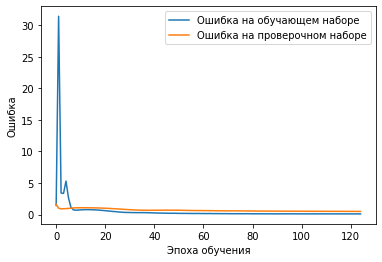

In [ ]:
# Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Проанализировав данные выявил, что словарь "модель" содержит 3156 индексов что при выборке в 70 119 машин сильно засоряет данные мешая обучиться сети и увеличивает количество ошибок. Решил попробовать обучить сеть исключив данный столбец. Вероятно нужно с ним особо прорабатывать распарсивая его на важные ключи или добавляя в более сложных сетях иным способом. Вобщем стоит подумать над ним дополнительно.

In [ ]:
# Создаём пустую обучающую выборку 2 version
x_train = []
y_train = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])
  
  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [ ]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [ ]:
x_test_new = x_train[60000:]
x_train_new = x_train[:60000]

In [ ]:
print(x_test_new.shape)
print(x_train_new.shape)

(10119, 52)
(60000, 52)


In [ ]:
y_train_new = y_train_scaled[:60000]
y_test_new = y_train_scaled[60000:]

In [ ]:
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)
print(x_train_new.shape)
print(x_test_new.shape)
print(y_train_new.shape)
print(y_test_new.shape)

(60000, 52)
(10119, 52)
(60000,)
(10119,)


In [ ]:
print(x_train_new.shape[1:])
print(x_test_new.shape[1:])
print(y_train_new.shape[1:])
print(y_test_new.shape[1:])

(52,)
(52,)
()
()


In [ ]:
model_ula = Sequential()
model_ula.add(BatchNormalization(input_shape=(52,)))
model_ula.add(Dense(52, activation = 'relu', ))
model_ula.add(Dropout(0.5, input_shape=(52,)))
model_ula.add(Dense(10, activation = 'relu'))
model_ula.add(Dropout(0.25, input_shape=(52,)))
model_ula.add(Dense(1, activation='linear'))
model_ula.compile(optimizer = 'adam', loss = 'mae')

print(model_ula.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 52)               208       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 52)                2756      
                                                                 
 dropout_2 (Dropout)         (None, 52)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                530       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                      

In [ ]:
# training
history_sec = model_ula.fit(x_train, y_train_scaled, epochs = 125, batch_size = 5200, validation_split = 0.1,  verbose=1) # batch_size в обоих случаях соответствует длине вектора в 100 машин.

Epoch 1/125
13/13 [==============================] - 1s 19ms/step - loss: 0.9282 - val_loss: 0.5178
Epoch 2/125
13/13 [==============================] - 0s 8ms/step - loss: 0.6856 - val_loss: 0.5212
Epoch 3/125
13/13 [==============================] - 0s 8ms/step - loss: 0.5801 - val_loss: 0.5084
Epoch 4/125
13/13 [==============================] - 0s 7ms/step - loss: 0.5192 - val_loss: 0.4868
Epoch 5/125
13/13 [==============================] - 0s 9ms/step - loss: 0.4842 - val_loss: 0.4605
Epoch 6/125
13/13 [==============================] - 0s 8ms/step - loss: 0.4572 - val_loss: 0.4365
Epoch 7/125
13/13 [==============================] - 0s 8ms/step - loss: 0.4343 - val_loss: 0.4153
Epoch 8/125
13/13 [==============================] - 0s 8ms/step - loss: 0.4116 - val_loss: 0.3945
Epoch 9/125
13/13 [==============================] - 0s 8ms/step - loss: 0.3950 - val_loss: 0.3737
Epoch 10/125
13/13 [==============================] - 0s 8ms/step - loss: 0.3793 - val_loss: 0.3559
Epoch 11

В итоге - val_loss: 0.5565 уменьшился до val_loss: 0.1388. На мой взгляд существенно.

In [ ]:
x = x_test_new[10][None,:]
predict = model_ula.predict(x)
predict_inverse = y_scaler.inverse_transform(predict).flatten()
print("Нейронная сеть подсчитала результат: цена автомобиля",predict_inverse, "рублей")

Нейронная сеть подсчитала результат: цена автомобиля [284322.6] рублей


In [ ]:
y=y_test_new[10].reshape(-1,1)

In [ ]:
test_price = y_scaler.inverse_transform(y).flatten()
"Тестовое значение цены автомобиля: ",test_price, "рублей"

('Тестовое значение цены автомобиля: ', array([319000.]), 'рублей')

Данный вариент использования данных делает сеть точнее, т.к. меньше замусоривает вектор и снижает процент ошибки.

In [ ]:
# Значения loss на обучающей выборке по эпохам
history_sec.history['loss']

In [ ]:
history_sec.history['val_loss']

In [ ]:
# Значения точности распознавания на проверочной выборке по эпохам
val_loss_mae_sec = []
val_loss = history_sec.history['val_loss']
for i in range(len(val_loss)):
  val_loss_mae_sec.append(val_loss[i])
  print("Эпоха: ", i, " точность: ", round(100*val_loss[i], 1), "%", sep="")
  # round - округление
  # sep="" - убрать стандартный разделитель пробел при выводе строки

Эпоха: 0 точность: 51.8%
Эпоха: 1 точность: 52.1%
Эпоха: 2 точность: 50.8%
Эпоха: 3 точность: 48.7%
Эпоха: 4 точность: 46.1%
Эпоха: 5 точность: 43.7%
Эпоха: 6 точность: 41.5%
Эпоха: 7 точность: 39.4%
Эпоха: 8 точность: 37.4%
Эпоха: 9 точность: 35.6%
Эпоха: 10 точность: 34.0%
Эпоха: 11 точность: 32.7%
Эпоха: 12 точность: 31.6%
Эпоха: 13 точность: 30.5%
Эпоха: 14 точность: 29.6%
Эпоха: 15 точность: 28.9%
Эпоха: 16 точность: 27.8%
Эпоха: 17 точность: 27.3%
Эпоха: 18 точность: 26.8%
Эпоха: 19 точность: 26.0%
Эпоха: 20 точность: 25.7%
Эпоха: 21 точность: 25.2%
Эпоха: 22 точность: 24.4%
Эпоха: 23 точность: 23.9%
Эпоха: 24 точность: 23.7%
Эпоха: 25 точность: 23.1%
Эпоха: 26 точность: 22.6%
Эпоха: 27 точность: 22.1%
Эпоха: 28 точность: 21.5%
Эпоха: 29 точность: 21.4%
Эпоха: 30 точность: 20.9%
Эпоха: 31 точность: 20.5%
Эпоха: 32 точность: 20.4%
Эпоха: 33 точность: 20.1%
Эпоха: 34 точность: 19.6%
Эпоха: 35 точность: 19.3%
Эпоха: 36 точность: 19.1%
Эпоха: 37 точность: 19.0%
Эпоха: 38 точность: 18

In [ ]:
val_loss_mae_sec = np.array(val_loss_mae_sec) # Массив значений ошибк на тестовой выборке
print('Среднее значение ошибки составило:', val_loss_mae.mean())

Среднее значение ошибки составило: 0.6845497527122497


In [ ]:
print('Средний процент ошибки составил: ', round(100*val_loss_mae_sec.mean()), '%', sep="")

Средний процент ошибки составил: 20%


In [ ]:
print("Средняя цена в тестовой выборке: ",round(y_train[60000:].mean()), "рублей.")

Средняя цена в тестовой выборке:  530277 рублей.


In [ ]:
print("Средняя цена : ",round(y_train.mean()), "рублей.")

Средняя цена :  527726 рублей.


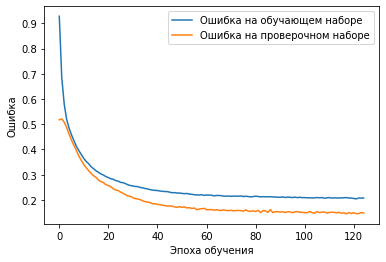

In [ ]:
# Выводим графики ошибки
plt.plot(history_sec.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history_sec.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()